In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

In [18]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [19]:
tmp = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

median_rating = tmp['averageRating'].median()

In [20]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


tmp = tmp.sort_values(by='Movie release date')
tmp['ReleaseYearRange'] = tmp['Movie release date'].apply(lambda x: create_range(x))

In [21]:
display(tmp)

,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,awards,nominations,movie_count,movie_count_genre,genres_b4,IsDrama,isMale,age_at_release,averageRating,ReleaseYearRange
IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,,,
tt0021061,nm0642988,1,24383800,Let's Go Native,1930,Jack Oakie,1903,0,0,1,1,2,0,1,27,5.8,1930 - 1940
tt0021324,nm0000802,1,5884622,The Runaway Bride,1930,Mary Astor,1906,0,0,1,1,7,0,0,24,4.9,1930 - 1940
tt0021233,nm0823597,1,32828818,Pardon My Gun,1930,Sally Starr,1909,0,0,1,0,1,0,0,21,4.3,1930 - 1940
tt0020690,nm0002001,1,142837,The Big Pond,1930,Maurice Chevalier,1888,0,1,1,0,7,0,1,42,5.7,1930 - 1940
tt0020806,nm0938464,1,2134118,Danger Lights,1930,Louis Wolheim,1880,0,0,1,0,1,1,1,50,6.1,1930 - 1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2126282,nm3070408,1,31656709,Ekk Deewana Tha,2012,Prateik Patil Babbar,1986,0,0,1,1,6,1,<NA>,26,6.1,2010 - 2020
tt2351177,nm3054665,1,35279558,Bhooter Bhabishyat,2012,Swastika Mukherjee,1980,0,0,1,0,1,0,0,32,8.1,2010 - 2020
tt1623288,nm2240346,1,31804949,ParaNorman,2012,Kodi Smit-McPhee,1996,0,0,2,1,7,0,1,16,7.0,2010 - 2020


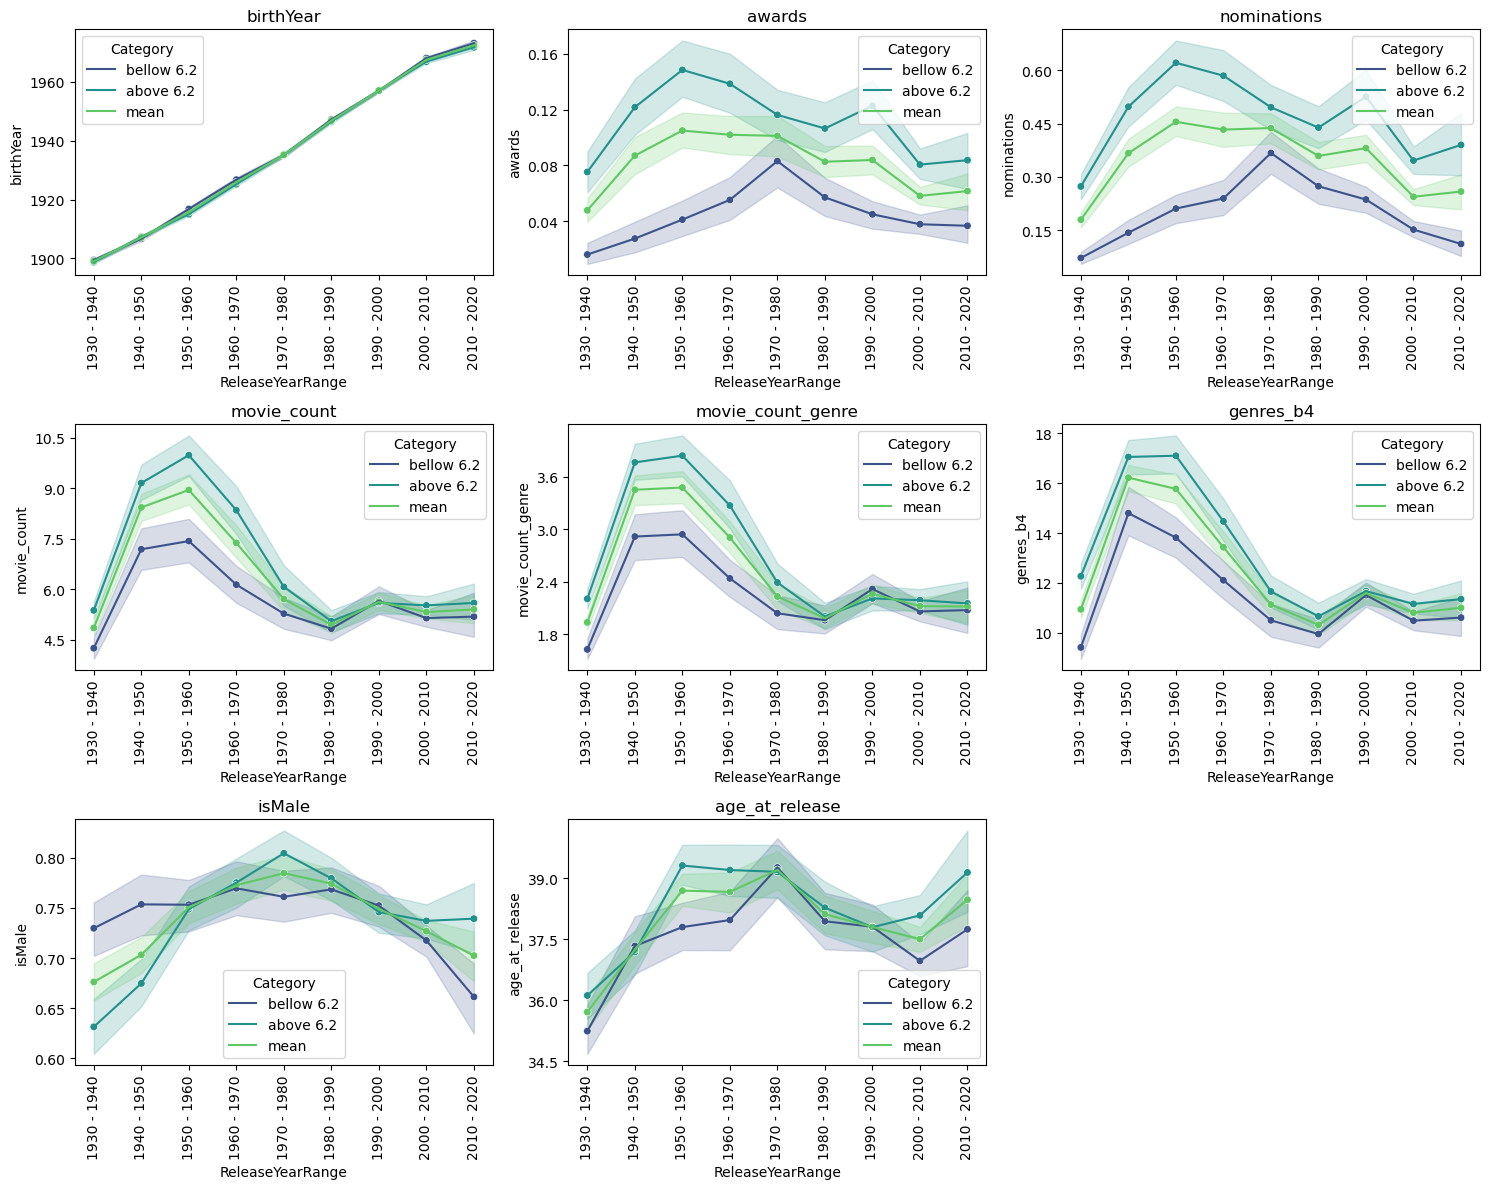

In [39]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(tmp, 'median_rating', 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])

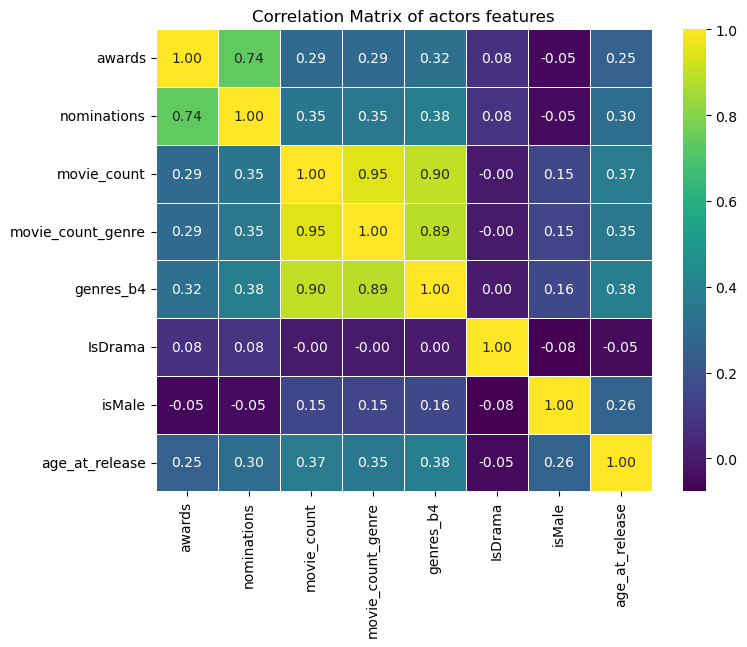

In [42]:
# Calculate the correlation matrix
correlation_matrix = actors['Features'].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

**High correlations**
- 0.95: Movie count vs Movie count in drama 
- 0.90: Movie count vs Genres diversity
- 0.89: Movie count in drama vs Genres diversity
- 0.74: Nominations vs Awards
